In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
trades_1 = pd.read_csv("round5/trades_round_5_day_2.csv", delimiter=';')
trades_2 = pd.read_csv("round5/trades_round_5_day_3.csv", delimiter=';')
trades_2['timestamp'] += 1e6
trades_3 = pd.read_csv("round5/trades_round_5_day_4.csv", delimiter=';')
trades_3['timestamp'] += 2e6

prices_1 = pd.read_csv("round5/prices_round_5_day_2.csv", delimiter=';')
prices_2 = pd.read_csv("round5/prices_round_5_day_3.csv", delimiter=';')
prices_2['timestamp'] += 1e6
prices_3 = pd.read_csv("round5/prices_round_5_day_4.csv", delimiter=';')
prices_3['timestamp'] += 2e6

In [3]:
prices = pd.concat([prices_1, prices_2, prices_3])
trades = pd.concat([trades_1, trades_2, trades_3])

def simple_mid_price(row):
    bid = row[3]
    ask = row[9]
    if np.isnan(bid):
        bid = 0
    elif np.isnan(ask):
        ask = 0
    return (bid+ask) / 2

prices['mid_price'] = prices.apply(simple_mid_price, axis=1)

C:\Users\chris\AppData\Local\Temp\ipykernel_500\2318256402.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bid = row[3]
C:\Users\chris\AppData\Local\Temp\ipykernel_500\2318256402.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ask = row[9]


In [4]:
croissants = prices[prices['product'] == 'CROISSANTS']['mid_price'].values
djembes = prices[prices['product'] == 'DJEMBES']['mid_price'].values
jams = prices[prices['product'] == 'JAMS']['mid_price'].values
basket1 = prices[prices['product'] == 'PICNIC_BASKET1']['mid_price'].values
basket2 = prices[prices['product'] == 'PICNIC_BASKET2']['mid_price'].values

timestamps = prices[prices['product'] == 'PICNIC_BASKET1']['timestamp'].values

premium_1 = basket1 - croissants * 6 - jams * 3 - djembes * 1
# premium_2 = basket2 - croissants * 6 - jams * 2 - djembes * 1

premium_1_df = pd.DataFrame({
    'timestamp': timestamps,
    'premium_1': premium_1
})
premium_1_df 

,timestamp,premium_1
0,0.0,136.0
1,100.0,139.5
2,200.0,144.5
3,300.0,145.5
4,400.0,138.5
...,...,...
29995,2999500.0,-127.0
29996,2999600.0,-124.5
29997,2999700.0,-121.5
29998,2999800.0,-121.0


In [5]:
buyers = set(trades['buyer'].unique())
sellers = set(trades['seller'].unique())

print("buyers: ", len(buyers))
print(buyers)
print("sellers: ", len(sellers))
print(sellers)

buyers_and_sellers = set.union(buyers, sellers)
print("buyers and sellers: ", len(buyers_and_sellers))

print(buyers_and_sellers)

buyers:  10
{'Charlie', 'Olivia', 'Peter', 'Gary', 'Paris', 'Penelope', 'Caesar', 'Gina', 'Pablo', 'Camilla'}
sellers:  11
{'Charlie', 'Olivia', 'Peter', 'Gary', 'Paris', 'Penelope', 'Caesar', 'Gina', 'Pablo', 'Olga', 'Camilla'}
buyers and sellers:  11
{'Peter', 'Paris', 'Caesar', 'Gina', 'Pablo', 'Camilla', 'Charlie', 'Olivia', 'Gary', 'Penelope', 'Olga'}


In [70]:
combos = []

for buyer in buyers:
    for seller in sellers:
        if buyer != seller:
            combos.append((buyer, seller))

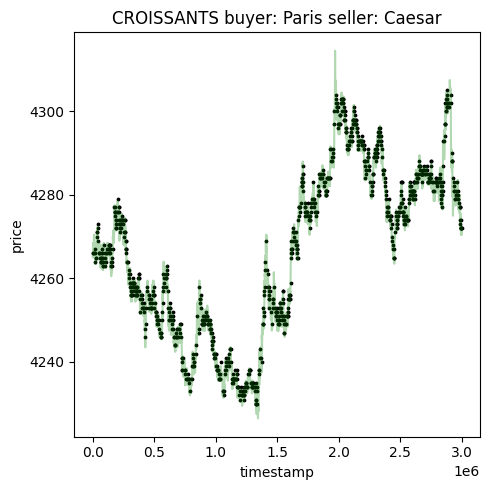

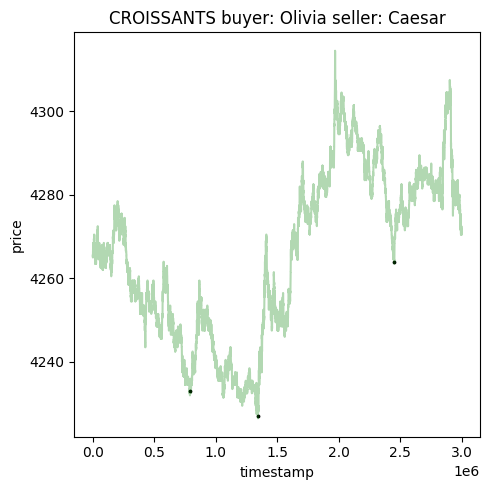

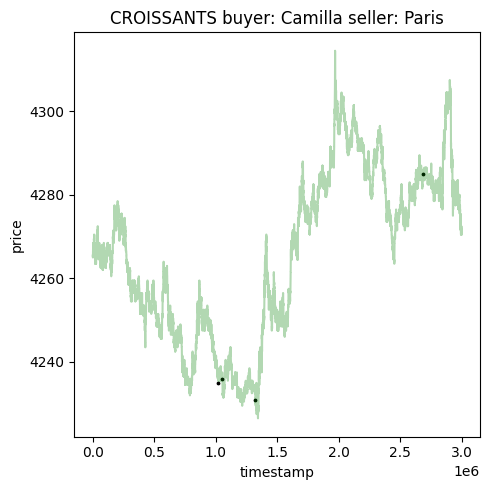

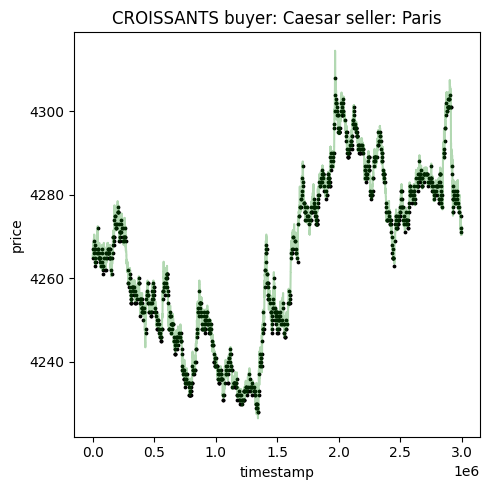

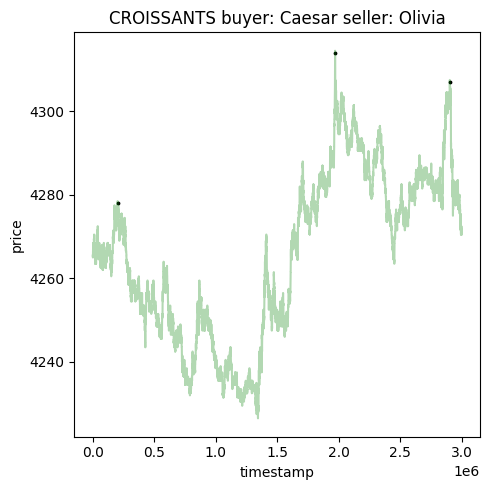

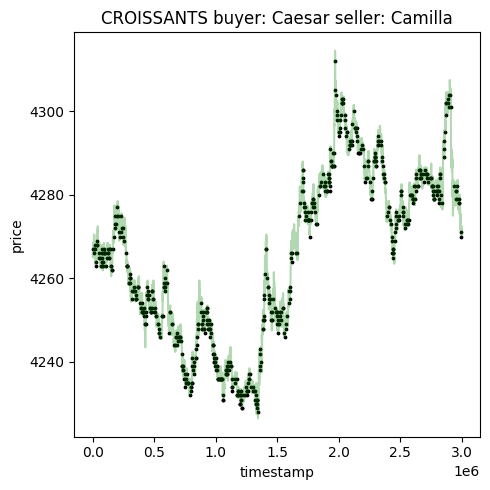

In [75]:
product = 'CROISSANTS'

for buyer, seller in combos:
    trades_df = trades[trades['symbol'] == product]
    trades_df = trades_df[(trades_df['buyer'] == buyer) & (trades_df['seller'] == seller)]
    price_df = prices[prices['product'] == product]

    if len(trades_df) == 0:
        continue

    plt.figure(figsize=(5, 5))
    plt.title(f"{product} buyer: {buyer} seller: {seller}")
    plt.plot(price_df['timestamp'], price_df['mid_price'], label='price', c='green', alpha=0.3)
    plt.scatter(trades_df['timestamp'], trades_df['price'], c='Black', s=3)
    plt.xlabel('timestamp')
    plt.ylabel('price')
    plt.tight_layout()

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:21<00:00, 1410.95it/s]


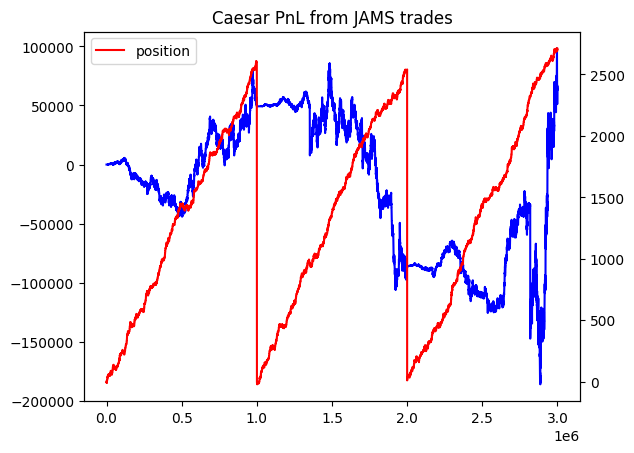

In [139]:
product = 'JAMS'
pnls, timestamps, positions = backtest_trader(trader, product, trades, prices)

plt.title(f"{trader} PnL from {product} trades")
plt.plot(timestamps, pnls, label='PnL', c='blue')
plt.twinx()
plt.plot(timestamps, positions, label='position', c='red')
plt.legend()

In [ ]:
from tqdm import tqdm

def backtest_trader(trader, product, trades, prices):

    trader_df = trades[(trades['buyer'] == trader) | (trades['seller'] == trader)] # filter on trader
    trader_df = trader_df[trader_df['symbol'] == product] # filter on product
    product_prices = prices[prices['product'] == product] # filter on product

    position = 0
    buy_costs = 0
    sell_costs = 0
    pnls = []
    positions = []
    timestamps = []
    prev_pnl = 0

    for i, row in tqdm(product_prices.iterrows(), total=len(product_prices)):
        time = row['timestamp']
        mid_price = row['mid_price']
        product = row['product']

        trades = trader_df[trader_df['timestamp'] == time]

        if time % 1e6 == 0.0:
            if position > 0:
                prev_pnl = (mid_price * position) - buy_costs + sell_costs + prev_pnl
            elif position < 0:
                prev_pnl = sell_costs - buy_costs - (mid_price * abs(position)) + prev_pnl
            else:
                prev_pnl = sell_costs - buy_costs

            position = 0
            buy_costs = 0
            sell_costs = 0

        for j, trade in trades.iterrows():
            symbol = trade['symbol']
            if symbol != product:
                continue

            if trade['buyer'] == trader:
                position += trade['quantity']
                buy_costs += trade['price'] * trade['quantity']
            
            elif trade['seller'] == trader:                    
                position -= trade['quantity']
                sell_costs += trade['price'] * trade['quantity']
        
        if position > 0:
            pnl = (mid_price * position) - buy_costs + sell_costs + prev_pnl
    
        elif position < 0:
            pnl = sell_costs - buy_costs - (mid_price * abs(position)) + prev_pnl

        else:
            pnl = sell_costs - buy_costs + prev_pnl

        pnls.append(pnl)
        timestamps.append(time)
        positions.append(position)
    
    return pnls, timestamps, positions

Notes:
- Olivia is a signal for tops/bottoms on squid ink, kelp, and croissants